## Skewed Data

In [1]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
pd.set_option('display.max_columns', None) # pandas show all columns of table instead of restricted
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig
from envirocar import inspection as inspect
from envirocar import manipulation as manipulate

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

In [2]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])

# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=20) 

In [3]:
tracks=track_df.copy()

We can have a look for the skewness of a distribution by applying the Fisher-Peason standardized moment coefficient on each column
The higher the value, the more the data is skewed
Negative values indicate negative left skewness
Generally a value < 1 is okay

In [4]:
inspect.skewness_num_variables(tracks)

,Skew
CO2.value,19.207353
Consumption.value,19.207353
Calculated MAF.value,19.207353
GPS HDOP.value,15.994399
GPS PDOP.value,15.985921
GPS VDOP.value,15.962941
GPS Accuracy.value,11.005252
Intake Pressure.value,10.057712
Engine Load.value,8.152091
Throttle Position.value,3.877674


Plot histograms to see the shape of the distribution of the data

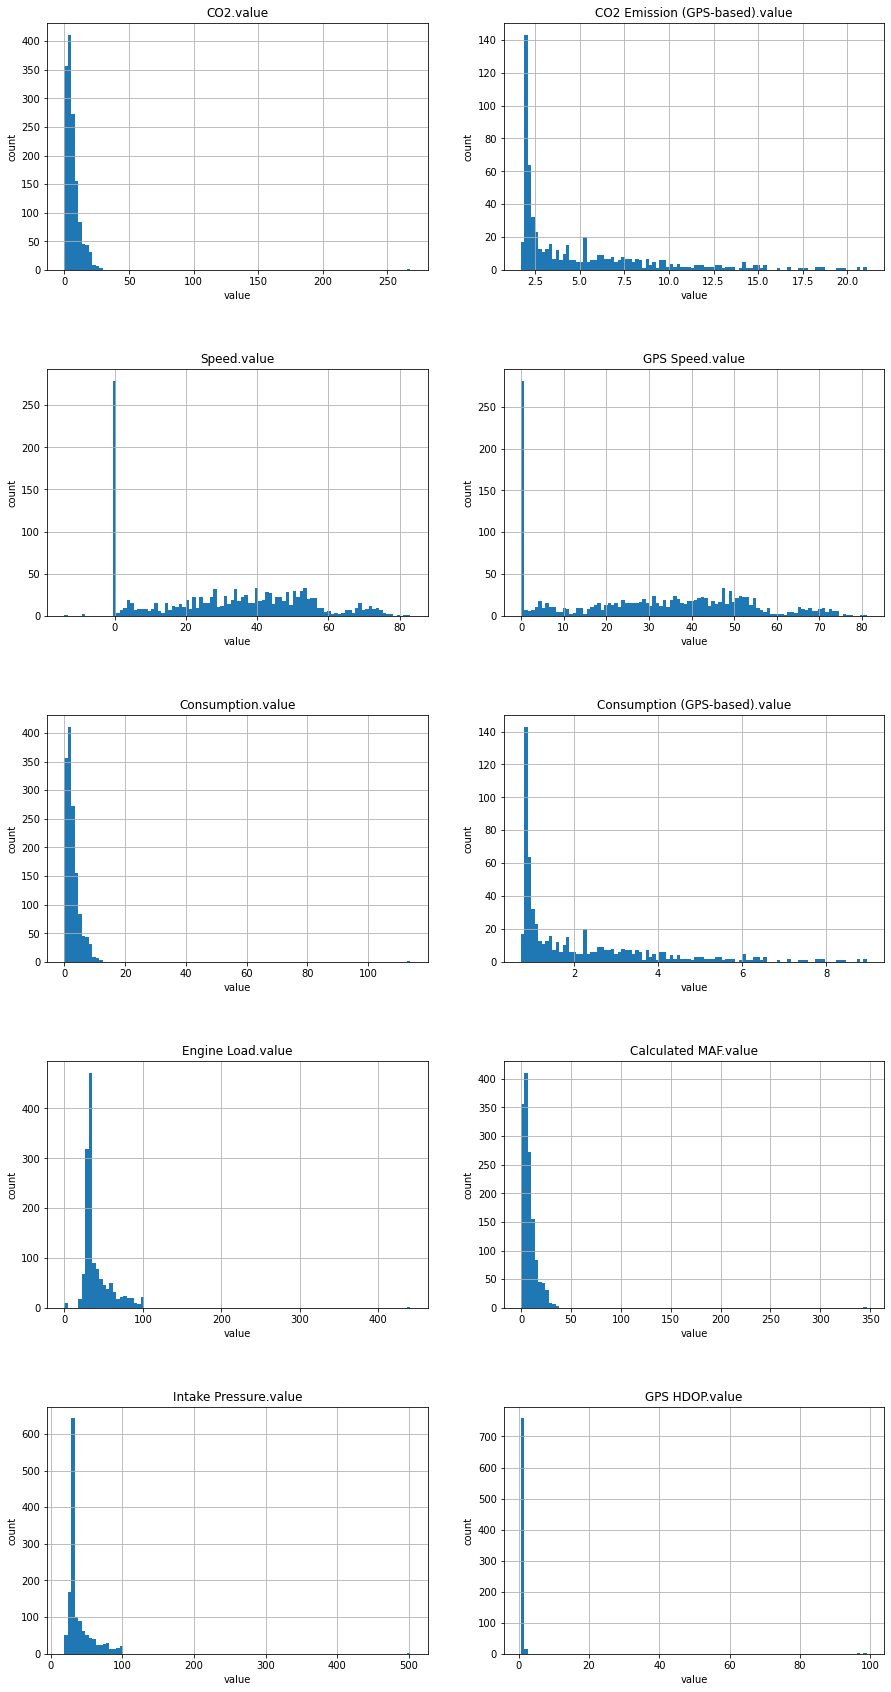

In [5]:
fig, axs = plt.subplots(5, 2,squeeze=False, figsize=(15,30))
plt.subplots_adjust(hspace=0.4)

axs[0, 0].hist(tracks["CO2.value"], bins=100)
axs[0, 0].set_title("CO2.value")

axs[0, 1].hist(tracks['CO2 Emission (GPS-based).value'], bins=100)
axs[0, 1].set_title('CO2 Emission (GPS-based).value')

axs[1, 0].hist(tracks['Speed.value'], bins=100)
axs[1, 0].set_title('Speed.value')

axs[1, 1].hist(tracks['GPS Speed.value'],bins=100)
axs[1, 1].set_title('GPS Speed.value')

axs[2, 0].hist(tracks['Consumption.value'], bins=100)
axs[2, 0].set_title('Consumption.value')

axs[2, 1].hist(tracks['Consumption (GPS-based).value'], bins=100)
axs[2, 1].set_title('Consumption (GPS-based).value')

axs[3, 0].hist(tracks['Engine Load.value'], bins=100)
axs[3, 0].set_title('Engine Load.value')

axs[3, 1].hist(tracks['Calculated MAF.value'], bins=100)
axs[3, 1].set_title('Calculated MAF.value')

axs[4, 0].hist(tracks['Intake Pressure.value'], bins=100)
axs[4, 0].set_title('Intake Pressure.value')

axs[4, 1].hist(tracks['GPS HDOP.value'], bins=100)
axs[4, 1].set_title('GPS HDOP.value')

for ax in axs.flat:
    ax.grid()
    ax.set(xlabel='value', ylabel='count')

We would like to analyse analyse Intake Pressure with a simple linear regression. Therefore we would need to transform the variable to a more normally distributed shape.   
Usually you would first clean the data (especially removing outlier) but as we only like to show different approaches of transformation for skewed data, we will just go ahead.

In [6]:
track_df['Intake Pressure.value'].describe()

count    1420.000000
mean       40.213202
std        24.478013
min        19.000000
25%        29.999999
50%        31.000000
75%        45.009750
max       502.171124
Name: Intake Pressure.value, dtype: float64

We can see, that the data is often right skewed (or: 'positve skewed'). If we use parametric approaches to analyse the data we would consider to shift data to a normal distribution.

Some ML algorithms need normalization, e.g. ANNs.  
So we should normalize our data. This will transform the values to be between 0 and 1 while not changing the shape of the distribution. 

In [7]:
normalized = manipulate.normalize(tracks)

After we normalized the data, we can see much better that the distribution is skewed. The values should be spread over 0-1.0, with the mean and median in the optimal case at about 0.5. However, we see here, that the mean is at 0.2 and the median at 0.12.

In [8]:
normalized['Intake Pressure.value'].describe()

count    1420.000000
mean        0.193301
std         0.224291
min         0.000000
25%         0.057361
50%         0.120203
75%         0.203055
max         1.000000
Name: Intake Pressure.value, dtype: float64

This skewness can also be seen when we look at the histogram

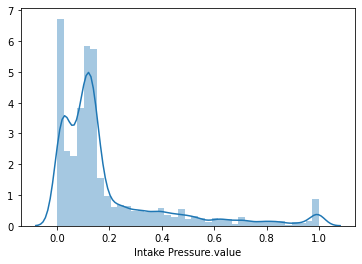

In [9]:
inspect.plot_hist(normalized, 'Intake Pressure.value')

In [10]:
normalized['Intake Pressure.value'].skew()

2.075568213914333

 We can transform the data to addess this skewness with different transformations.

### Log transformation

In [23]:
log=manipulate.log_transformation(normalized, 'Intake Pressure.value')

count    1420.000000
mean        0.162191
std         0.162751
min         0.000000
25%         0.055776
50%         0.113510
75%         0.184864
max         0.693147
Name: Intake Pressure.value, dtype: float64


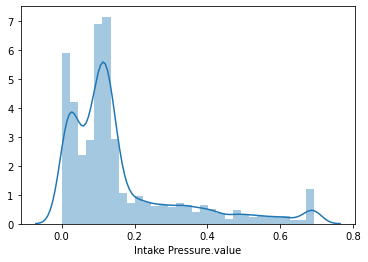

In [12]:
inspect.plot_hist(log)

In [13]:
log.skew()

1.7171878723324194

### Square root transformation

count    1420.000000
mean        0.381549
std         0.218529
min         0.000000
25%         0.239499
50%         0.346703
75%         0.450616
max         1.000000
Name: Intake Pressure.value, dtype: float64


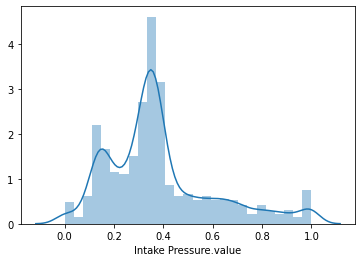

In [22]:
squareRoot=manipulate.squareRoot_transformation(normalized,'Intake Pressure.value')
inspect.plot_hist(squareRoot)

In [15]:
squareRoot.skew()

1.0153401208803627

### Reciprocal Transformation

count    1420.000000
mean        0.860607
std         0.122567
min         0.500000
25%         0.831217
50%         0.892695
75%         0.945751
max         1.000000
Name: Intake Pressure.value, dtype: float64


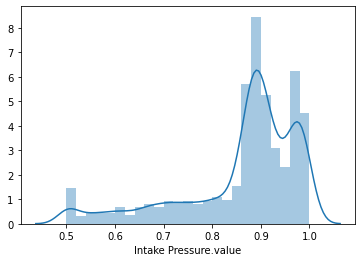

In [20]:
reciprocal = manipulate.reciprocal_transformation(normalized,'Intake Pressure.value' )
inspect.plot_hist(reciprocal)

In [21]:
reciprocal.skew()

-1.3823593536757748